**BINAY CLASSIFICATION WITH PYTORCH**

*DATASETS : sklearn.datasets.make_moons*

1. Import necessary library

In [15]:
! pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import torchmetrics as tm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

2. Creating data from sklean.datasets.make_moons

In [17]:
N_SAMPLES = 1000
NOISE = 0.1

In [18]:
x,y = make_moons(n_samples=N_SAMPLES,noise=NOISE)

x = torch.from_numpy(x).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

3. Visualize data

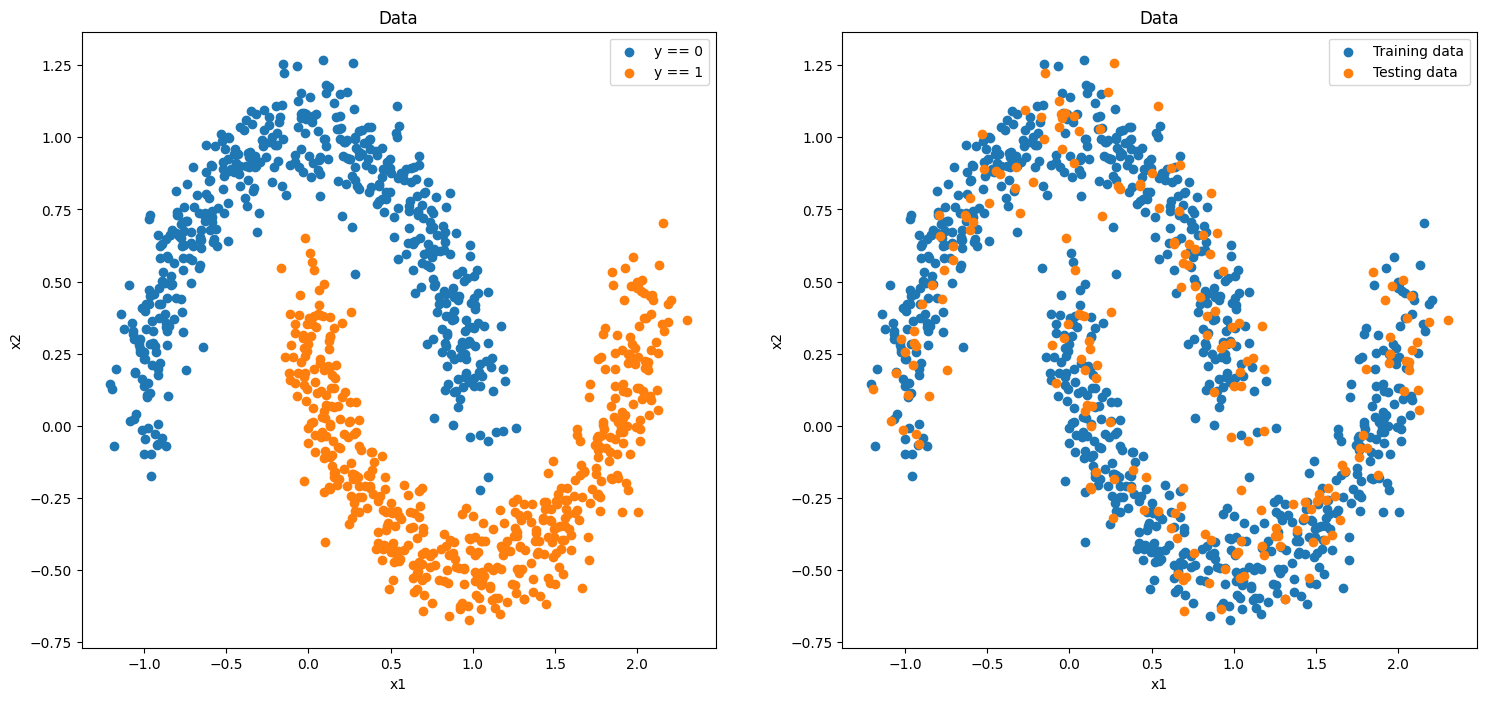

In [19]:
plt.figure(figsize=(18,8))

plt.subplot(1,2,1)
plt.scatter(x[y==0][:,0],x[y==0][:,1],label="y == 0")
plt.scatter(x[y==1][:,0],x[y==1][:,1],label="y == 1")
plt.title("Data")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()

plt.subplot(1,2,2)
plt.scatter(x_train[:,0],x_train[:,1],label="Training data")
plt.scatter(x_test[:,0],x_test[:,1],label="Testing data")
plt.title("Data")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()

4. Build model

In [20]:
class BinaryModelV0(nn.Module):
    def __init__(self):
        super().__init__()

        self.linear1 = nn.Linear(in_features=2,out_features=8)
        self.linear2 = nn.Linear(in_features=8,out_features=8)
        self.linear3 = nn.Linear(in_features=8,out_features=1)
        self.relu = nn.ReLU()
    
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        layer1 = self.linear1(x)
        layer2 = self.linear2(self.relu(layer1))
        layer3 = self.linear3(self.relu(layer2))
        return layer3

In [21]:
model = BinaryModelV0()
print(model)
model.state_dict()

BinaryModelV0(
  (linear1): Linear(in_features=2, out_features=8, bias=True)
  (linear2): Linear(in_features=8, out_features=8, bias=True)
  (linear3): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
)


OrderedDict([('linear1.weight',
              tensor([[ 0.1767,  0.1297],
                      [ 0.6716, -0.4274],
                      [ 0.4379, -0.2580],
                      [ 0.6764, -0.3645],
                      [ 0.5612,  0.2607],
                      [-0.2180,  0.0855],
                      [ 0.4027, -0.0967],
                      [ 0.4482, -0.3017]])),
             ('linear1.bias',
              tensor([-0.6985, -0.2771, -0.4009,  0.1144, -0.0605, -0.2292,  0.6331,  0.5517])),
             ('linear2.weight',
              tensor([[ 0.0629, -0.3065, -0.0437,  0.2005,  0.2951,  0.3320,  0.3416,  0.0805],
                      [-0.0930, -0.3148,  0.1964, -0.0407,  0.1664, -0.2064, -0.3149, -0.2887],
                      [ 0.0481, -0.2301, -0.1661,  0.1611, -0.1571,  0.0990,  0.1617, -0.1913],
                      [ 0.2377,  0.2310,  0.1618,  0.0300, -0.1835, -0.1274, -0.1870, -0.1700],
                      [-0.3127,  0.0901, -0.3521, -0.3294,  0.1152,  0.3068,  0.2008, 

Test model with parameters random

In [22]:
model.eval()
with torch.inference_mode():
    y_pred = model(x_test).squeeze()
    y_pred_label = torch.round(torch.sigmoid(y_pred))
    print(y_pred_label[:10])
    print(y_test[:10])

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([1., 1., 0., 0., 1., 0., 1., 1., 0., 1.])


5. Initialization loss_fn and optimizer

In [23]:
loss_fn = nn.BCEWithLogitsLoss()
opt = torch.optim.SGD(params=model.parameters(),lr=0.08)

6. Creating loop with epoch = 2000 to training model

In [24]:
EPOCHS = 3000
epoch_list = []
loss_train_list = []
loss_test_list = []
acc_train_list = []
acc_test_list = []
binary_acc = tm.Accuracy(task="binary", num_classes=2)

for epoch in range(EPOCHS):
    # training
    model.train()

    y_pred_train = model(x_train).squeeze()
    loss_train = loss_fn(y_pred_train,y_train)

    y_pred_label = torch.round(torch.sigmoid(y_pred_train))
    acc_train = binary_acc(y_pred_label,y_train)

    opt.zero_grad()
    loss_train.backward()
    opt.step()

    # evaluting
    model.eval()
    with torch.inference_mode():
        y_pred_test = model(x_test).squeeze()
        loss_test = loss_fn(y_pred_test,y_test)

        y_pred_label = torch.round(torch.sigmoid(y_pred_test))
        acc_test = binary_acc(y_pred_label,y_test)

        if epoch % 150 == 0 :
            print(f"Epoch {epoch}# Loss train : {loss_train}, Acc train : {acc_train} --- Loss test : {loss_test}, Acc test : {acc_test}")

            epoch_list.append(epoch)
            loss_train_list.append(loss_train.detach().numpy())
            loss_test_list.append(loss_test.detach().numpy())
            acc_train_list.append(acc_train)
            acc_test_list.append(acc_test)

Epoch 0# Loss train : 0.6805768013000488, Acc train : 0.5012500286102295 --- Loss test : 0.6795696020126343, Acc test : 0.4950000047683716
Epoch 150# Loss train : 0.32838428020477295, Acc train : 0.8424999713897705 --- Loss test : 0.38157668709754944, Acc test : 0.7950000166893005
Epoch 300# Loss train : 0.19800905883312225, Acc train : 0.9212499856948853 --- Loss test : 0.28537219762802124, Acc test : 0.875
Epoch 450# Loss train : 0.15910372138023376, Acc train : 0.9375 --- Loss test : 0.2481500804424286, Acc test : 0.8899999856948853
Epoch 600# Loss train : 0.11939805746078491, Acc train : 0.9549999833106995 --- Loss test : 0.19641433656215668, Acc test : 0.9200000166893005
Epoch 750# Loss train : 0.08129975199699402, Acc train : 0.981249988079071 --- Loss test : 0.1407376527786255, Acc test : 0.9599999785423279
Epoch 900# Loss train : 0.05418280139565468, Acc train : 0.9887499809265137 --- Loss test : 0.09708020836114883, Acc test : 0.9649999737739563
Epoch 1050# Loss train : 0.0380

7. Evaluting model after training

In [25]:
model.eval()
with torch.inference_mode():
    y_pred = model(x_test).squeeze()
    y_pred_label = torch.round(torch.sigmoid(y_pred))
    print(y_pred_label[:10])
    print(y_test[:10])

tensor([1., 1., 0., 0., 1., 0., 1., 1., 0., 1.])
tensor([1., 1., 0., 0., 1., 0., 1., 1., 0., 1.])


8. Visualize loss and accuracy

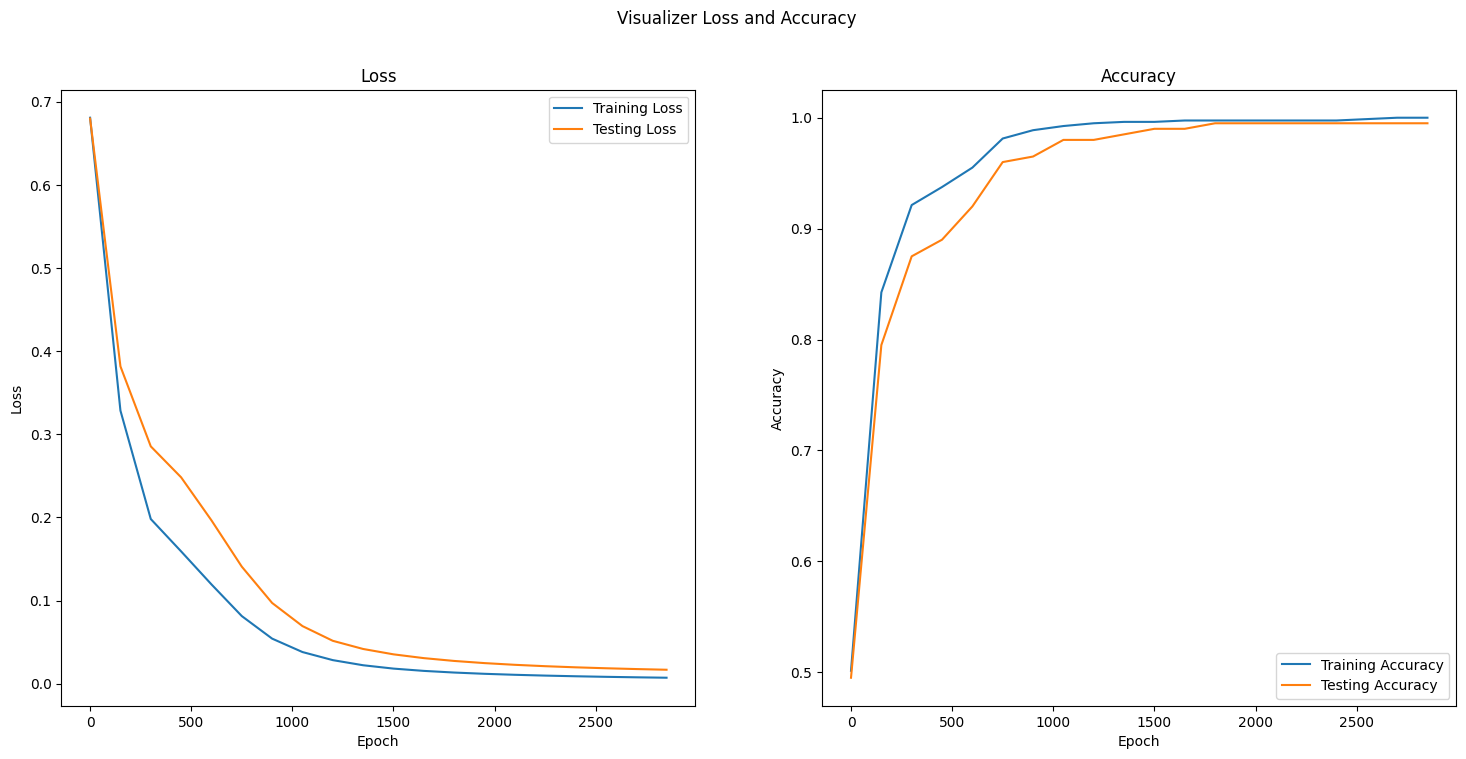

In [26]:
plt.figure(figsize=(18,8))
plt.suptitle("Visualizer Loss and Accuracy",)
plt.subplot(1,2,1)
plt.plot(epoch_list,loss_train_list,label="Training Loss")
plt.plot(epoch_list,loss_test_list,label="Testing Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epoch_list,acc_train_list,label="Training Accuracy")
plt.plot(epoch_list,acc_test_list,label="Testing Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

9. Visualize model non_linear

helper_functions.py already exists, skipping download


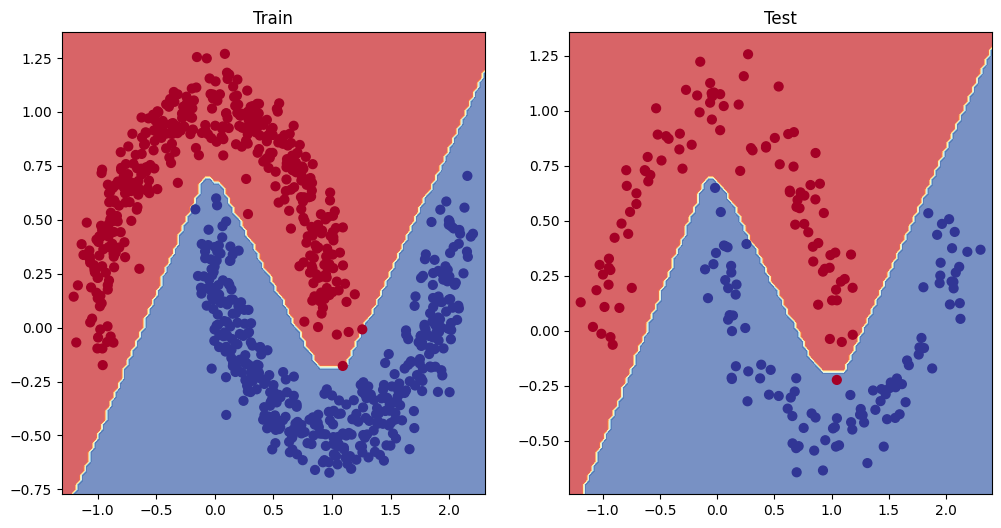

In [27]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, x_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, x_test, y_test)

10. Save model

In [29]:
from pathlib import Path

MODEL = Path("model")
MODEL.mkdir(parents=True,exist_ok=True)
MODEL_NAME = "make_moons_binary_classification_model.pth"
MODEL_PATH = MODEL / MODEL_NAME

torch.save(obj=model.state_dict(),f=MODEL_PATH)